# 沒有使用G@C回收設施的原因的demographics，比如：選擇[不想麻煩]的受訪者的[年齡層]分佈

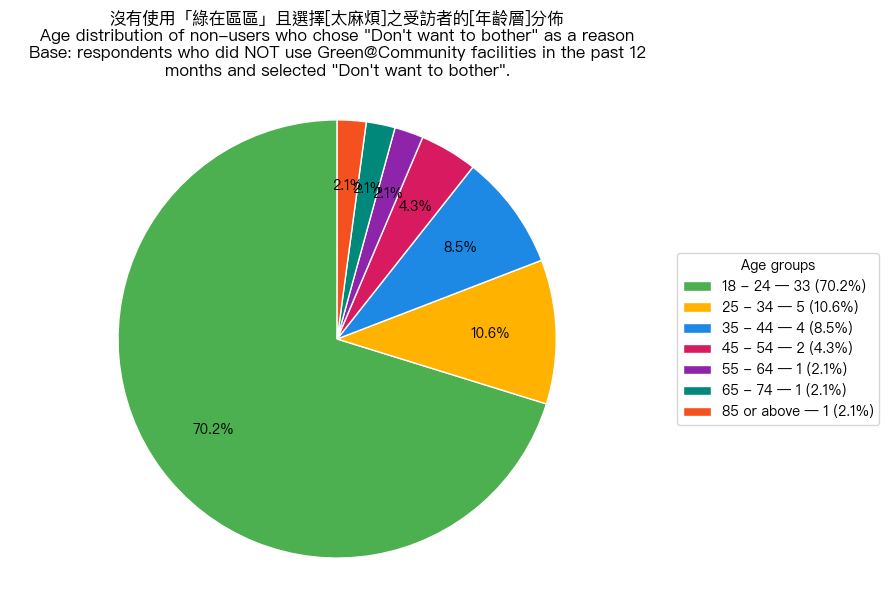

In [6]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")
_ensure("numpy")

# ---------- imports ----------
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
from textwrap import wrap

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- helper to find columns ----------
def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    return None

# Column: used G@C in past 12 months (Yes / No)
use_patterns = [
    r"in\s+the\s+past\s+12\s+months.*used\s+any\s+green@community\s+recycling\s+facility",
    r"在最近12個月.*有否使用過.*綠在區區.*回收設施",
]
use_col = find_col(df.columns, use_patterns)
if use_col is None:
    raise RuntimeError("Could not find the 'In the past 12 months, have you used any G@C facility?' column.")

# Column: reasons for NOT using G@C
reasons_patterns = [
    r"what\s+are\s+the\s+reasons\s+you\s+did\s+not\s+use\s+green@community\s+facilities\s+in\s+the\s+past\s+12\s+months",
    r"在過去12個月.*沒有使用.*綠在區區.*原因",
]
reasons_col = find_col(df.columns, reasons_patterns)
if reasons_col is None:
    raise RuntimeError("Could not find the 'reasons did not use G@C in past 12 months' column.")

# Column: Age
age_patterns = [r"\bage\b", r"年齡"]
age_col = find_col(df.columns, age_patterns)
if age_col is None:
    raise RuntimeError("Could not find the Age column.")

use_series     = df[use_col].astype(str)
reasons_series = df[reasons_col].fillna("").astype(str)
age_series     = df[age_col].astype(str)

# ---------- build masks ----------
# Non-users only (answered "No" to using G@C in past 12 months)
def is_no_use(v):
    s = str(v).strip().lower()
    return s in {"no", "n", "否", "沒有", "未有", "無"}

mask_non_user = use_series.map(is_no_use)

# Among non-users, those whose reasons include "Don't want to bother"
# ("too troublesome" in the questionnaire; cleaned-data wording prevails)
mask_too_trouble = reasons_series.str.contains("Don't want to bother", case=False, regex=False)

# Combined mask
mask_target = mask_non_user & mask_too_trouble

ages_target = age_series[mask_target].dropna().str.strip()

# ---------- count age groups ----------
age_order_pref = [
    "17 or below",
    "18 - 24",
    "25 - 34",
    "35 - 44",
    "45 - 54",
    "55 - 64",
    "65 - 74",
    "75 - 84",
    "85 or above",
]

counts_raw = ages_target.value_counts()
ordered_labels = [a for a in age_order_pref if a in counts_raw.index] + \
                 [a for a in counts_raw.index if a not in age_order_pref]

counts = [int(counts_raw.get(a, 0)) for a in ordered_labels]
total  = sum(counts)

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        plt.rcParams["font.family"] = font_name
        break
plt.rcParams["axes.unicode_minus"] = False

# ---------- legend labels ----------
pct = [(c / total * 100) if total > 0 else 0.0 for c in counts]
legend_labels = [
    f"{ordered_labels[i]} — {counts[i]} ({pct[i]:.1f}%)"
    for i in range(len(ordered_labels))
]

# ---------- plot pie chart (white background, legend on right) ----------
fig, ax = plt.subplots(figsize=(9, 6), facecolor="white")
ax.set_facecolor("white")

# use a colourful palette (Tab20) for clearer differences
base_colors = [
    "#4CAF50",  # green
    "#FFB300",  # amber/gold
    "#1E88E5",  # blue
    "#D81B60",  # magenta
    "#8E24AA",  # purple
    "#00897B",  # teal
    "#F4511E",  # orange-red (in case there are more slices)
    "#6D4C41",  # brown
]


wedges, text_labels, autotexts = ax.pie(
    counts,
    labels=None,  # use legend instead
    colors=base_colors[:len(counts)],
    startangle=90,
    autopct=(lambda p: f"{p:.1f}%") if total > 0 else None,
    pctdistance=0.7,
    wedgeprops=dict(edgecolor="white"),
)

ax.legend(
    wedges,
    legend_labels,
    title="Age groups",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0.0,
)

title_main = "沒有使用「綠在區區」且選擇[太麻煩]之受訪者的[年齡層]分佈\n" \
             "Age distribution of non-users who chose \"Don't want to bother\" as a reason"
title_sub  = "Base: respondents who did NOT use Green@Community facilities in the past 12 months and selected \"Don't want to bother\"."
wrapped_sub = "\n".join(wrap(title_sub, 80))

ax.set_title(title_main + "\n" + wrapped_sub, pad=16)

ax.axis("equal")  # keep pie circular
plt.tight_layout()
plt.show()


# 沒有使用G@C回收設施的原因的demographics，比如：選擇[不想麻煩]的受訪者的[人口]分佈

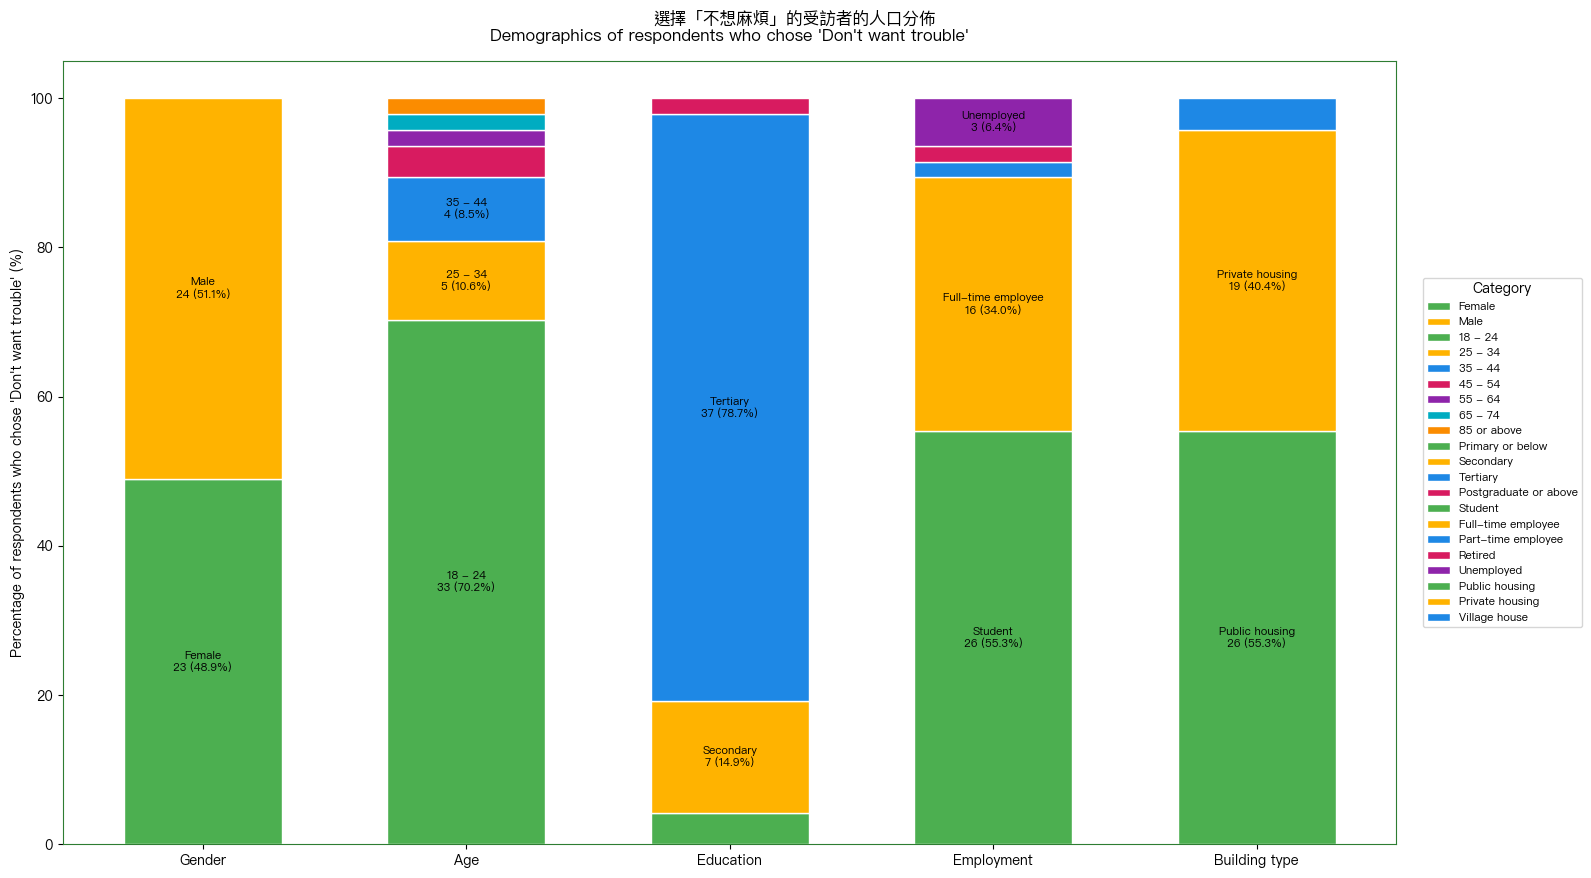

In [2]:
# ---------- install deps if missing ----------
import importlib, subprocess, sys
def _ensure(pkg, mod=None):
    try:
        importlib.import_module(mod or pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

_ensure("pandas")
_ensure("openpyxl")
_ensure("matplotlib")

# ---------- imports ----------
import re
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# ---------- load data ----------
data_path = Path("../GCAP3226 G@C Survey Responses_cleaned data.xlsx")
df = pd.read_excel(data_path, engine="openpyxl")

# ---------- helper to find columns by header pattern ----------
def find_col(columns, patterns):
    cols = [(c, re.sub(r"\s+", " ", str(c)).strip()) for c in columns]
    for c, norm in cols:
        if any(re.search(p, norm, flags=re.IGNORECASE) for p in patterns):
            return c
    return None

# column: reasons for NOT using G@C (multi-choice, text with commas)
no_use_patterns = [
    r"reasons\s+you\s+did\s+not\s+use\s+green@community\s+facilities",
    r"在過去12個月.*沒有使用.*綠在區區.*原因",
]
no_use_col = find_col(df.columns, no_use_patterns)
if no_use_col is None:
    raise RuntimeError("Could not find the 'reasons you did not use G@C' column.")

# demographic columns
gender_col = find_col(df.columns, [r"\bgender\b", r"性別"])
age_col    = find_col(df.columns, [r"\bage\b", r"年齡"])
edu_col    = find_col(df.columns, [r"education\s*level", r"教育程度"])
emp_col    = find_col(df.columns, [r"employment\s*status", r"就業狀況"])
bldg_col   = find_col(df.columns, [r"type\s+of\s+building\s+you\s+live\s+in", r"住宅樓宇類型"])

for c, name in [
    (gender_col, "Gender"),
    (age_col, "Age"),
    (edu_col, "Education level"),
    (emp_col, "Employment status"),
    (bldg_col, "Type of building you live in"),
]:
    if c is None:
        raise RuntimeError(f"Could not find the '{name}' column.")

no_use_series = df[no_use_col].astype(str)
gender_series = df[gender_col].astype(str)
age_series    = df[age_col].astype(str)
edu_series    = df[edu_col].astype(str)
emp_series    = df[emp_col].astype(str)
bldg_series   = df[bldg_col].astype(str)

# ---------- filter: respondents who selected "Don't want to bother / 不想麻煩" ----------
# In the cleaned file the English text is "Don't want to bother"
mask_dont = (
    no_use_series.str.contains("don't want to bother", case=False, na=False)
    | no_use_series.str.contains("don't want trouble", case=False, na=False)
    | no_use_series.str.contains("不想麻煩", na=False)
)

# ---------- helper to get ordered categories, counts, percentages ----------
def get_counts(series, mask, order_pref=None):
    s = series[mask].dropna().astype(str).str.strip()
    s = s[s != ""]
    counts_raw = s.value_counts()

    if order_pref is None:
        labels = list(counts_raw.index)
    else:
        labels = [c for c in order_pref if c in counts_raw.index] + \
                 [c for c in counts_raw.index if c not in (order_pref or [])]

    counts = [int(counts_raw.get(c, 0)) for c in labels]
    total = sum(counts)
    pct = [c / total * 100 if total > 0 else 0.0 for c in counts]
    return labels, counts, pct

age_order = [
    "17 or below",
    "18 - 24",
    "25 - 34",
    "35 - 44",
    "45 - 54",
    "55 - 64",
    "65 - 74",
    "75 - 84",
    "85 or above",
]
edu_order = [
    "Primary or below",
    "Secondary",
    "Tertiary",
    "Postgraduate or above",
]
emp_order = [
    "Student",
    "Full-time employee",
    "Part-time employee",
    "Housewife",
    "Retired",
    "Self employed",
    "Unemployed",
]
bldg_order = [
    "Public housing",
    "Private housing",
    "Village house",
]

gender_labels, gender_counts, gender_pct = get_counts(
    gender_series, mask_dont, ["Female", "Male", "Other"]
)
age_labels, age_counts, age_pct       = get_counts(age_series,  mask_dont, age_order)
edu_labels, edu_counts, edu_pct       = get_counts(edu_series,  mask_dont, edu_order)
emp_labels, emp_counts, emp_pct       = get_counts(emp_series,  mask_dont, emp_order)
bldg_labels, bldg_counts, bldg_pct    = get_counts(bldg_series, mask_dont, bldg_order)

variables = [
    ("Gender",        gender_labels, gender_counts, gender_pct),
    ("Age",           age_labels,    age_counts,    age_pct),
    ("Education",     edu_labels,    edu_counts,    edu_pct),
    ("Employment",    emp_labels,    emp_counts,    emp_pct),
    ("Building type", bldg_labels,   bldg_counts,   bldg_pct),
]

# Safety check — if nobody chose this option, stop with a clear error
if all(sum(v[2]) == 0 for v in variables):
    raise RuntimeError("No respondents selected 'Don't want to bother / 不想麻煩'.")

# ---------- fonts (Chinese-capable if available) ----------
for font_name in ["Noto Sans CJK TC", "PingFang TC", "PingFang HK",
                  "Microsoft JhengHei", "SimHei"]:
    if any(font_name in f.name for f in matplotlib.font_manager.fontManager.ttflist):
        matplotlib.rcParams["font.family"] = font_name
        break
matplotlib.rcParams["axes.unicode_minus"] = False

# ---------- stacked bar chart ----------
fig, ax = plt.subplots(figsize=(16, 9), facecolor="white")  # large figure for labels
ax.set_facecolor("white")

palette = [
    "#4CAF50",
    "#FFB300",
    "#1E88E5",
    "#D81B60",
    "#8E24AA",
    "#00ACC1",
    "#FB8C00",
    "#6D4C41",
    "#9CCC65",
    "#5E35B1",
]

x_pos = range(len(variables))
bar_width = 0.6
label_threshold = 6.0  # only label segments >= 6% to avoid overlap

legend_handles = []
legend_labels_all = []

for i, (_var_name, labels, counts, pct) in enumerate(variables):
    bottom = 0.0
    for j, (lab, c, p) in enumerate(zip(labels, counts, pct)):
        if c == 0:
            continue
        color = palette[j % len(palette)]
        bar = ax.bar(i, p, width=bar_width, bottom=bottom,
                     color=color, edgecolor="white")

        # collect for legend
        if lab not in legend_labels_all:
            legend_handles.append(bar[0])
            legend_labels_all.append(lab)

        if p >= label_threshold:
            ax.text(
                i,
                bottom + p / 2,
                f"{lab}\n{c} ({p:.1f}%)",
                ha="center",
                va="center",
                fontsize=8,
            )
        bottom += p

ax.set_xticks(list(x_pos))
ax.set_xticklabels([v[0] for v in variables], rotation=0, ha="center")

ax.set_ylabel("Percentage of respondents who chose 'Don't want trouble' (%)")
ax.set_ylim(0, 105)
ax.set_yticks(range(0, 101, 20))

border_color = "#2e7d32"
for spine in ax.spines.values():
    spine.set_color(border_color)

# legend on the right listing all categories
ax.legend(
    legend_handles,
    legend_labels_all,
    title="Category",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
    borderaxespad=0.0,
    fontsize=8,
)

title_cn = "選擇「不想麻煩」的受訪者的人口分佈"
title_en = "Demographics of respondents who chose 'Don't want trouble'"
fig.suptitle(title_cn, y=0.97)
ax.set_title(title_en, pad=14)

plt.tight_layout()
plt.show()
